In [1]:
import ast

import pandas as pd

import wn

from OMWMetricsExtractor import OMWMetricsExtractor

from utils import get_path_from_root, get_resource_word_match
from analyzer import OMWBasicnessAnalyzer
from utils_plot import plot_heatmap, plot_spaghettiplot, plot_clustermap

In [2]:
# Download the necessary resources if they are not already present
wn.download('omw:1.4')
wn.download('cili:1.0')

Cached file found: /home/evilscript/.wn_data/downloads/16c278c2e49cbeed749469012a4c6cfa078b2db4
Skipping omw-sl:1.4 (sloWNet); already added-sl.xml
Skipping omw-nn:1.4 (Norwegian Wordnet (Nynorsk)); already added
Skipping omw-da:1.4 (DanNet); already addedw-da.xml
Skipping omw-nb:1.4 (Norwegian Wordnet (Bokmål)); already added
Skipping omw-bg:1.4 (BulTreeBank Wordnet (BTB-WN)); already added
Skipping omw-th:1.4 (Thai Wordnet); already addedml
Skipping omw-hr:1.4 (Croatian Wordnet); already added
Skipping omw-it:1.4 (MultiWordNet (Italian)); already added
Skipping omw-is:1.4 (IceWordNet); already added.xml
Skipping omw-sk:1.4 (Slovak WordNet); already added
Skipping omw-fr:1.4 (WOLF (Wordnet Libre du Français)); already added
Skipping omw-ja:1.4 (Japanese Wordnet); already added
Skipping omw-nl:1.4 (Open Dutch WordNet); already added
Skipping omw-ro:1.4 (Romanian Wordnet); already added
Skipping omw-iwn:1.4 (ItalWordNet); already added.xml
Skipping omw-pl:1.4 (plWordNet); already addedl

PosixPath('/home/evilscript/.wn_data/downloads/93c4c7fc4f7218dba99a2c131f042accc2b0a2a4')

In [3]:
enable_plots = False
use_ili_list = False
langs = ("en", "it", "nb", "es")
# Choose resource set type: "mixed" (mixed random words), "important" (important words), "selected" (selected ilis/synsets), "culture" (all culture words)
resource_set_type = "annotation_culture_gold_it"
fixed_thresholds = [0.25, 0.5, 0.75]

In [4]:
if resource_set_type == "mixed":
    out_prefix = "mixed_words"
    input_path = get_path_from_root(f"resources/{out_prefix}_omw.csv")
    json_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.json")
    csv_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.csv")
    analysis_name = f"{out_prefix}_omw_scored"
elif resource_set_type == "important":
    out_prefix = "important_words"
    input_path = get_path_from_root(f"resources/{out_prefix}_omw.csv")
    json_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.json")
    csv_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.csv")
    analysis_name = f"{out_prefix}_omw_scored"
elif resource_set_type == "selected":
    out_prefix = "selected_ilis"
    selected_ilis_path = get_path_from_root("resources/selected_ilis_omw.csv")
    selected_words_path = get_path_from_root("resources/selected_words_omw.csv")
    json_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.json")
    csv_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.csv")
    analysis_name = f"{out_prefix}_omw_scored"
    synset_word_match_dict = get_resource_word_match(selected_ilis_path, selected_words_path)
elif resource_set_type == "culture":
    out_prefix = "all_culture"
    input_path = get_path_from_root(f"resources/culture/{out_prefix}.csv")
    json_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.json")
    csv_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.csv")
    analysis_name = f"{out_prefix}_omw_scored"
elif resource_set_type == "selected_culture":
    out_prefix = "selected_culture"
    input_path = get_path_from_root("resources/culture/ili_es_culture_filtered.csv")
    json_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.json")
    csv_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.csv")
    analysis_name = f"{out_prefix}_omw_scored"
elif resource_set_type == "annotation_culture":
    out_prefix = "annotation_culture_copy"
    input_path = get_path_from_root("resources/annotation/culture_annotated_silver_simple_majority_voting.xlsx")
    json_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.json")
    csv_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.csv")
    analysis_name = f"{out_prefix}_omw_scored"
elif resource_set_type == "annotation_culture_gold_it":
    out_prefix = "annotation_culture_gold_it_copy"
    input_path = get_path_from_root("resources/annotation/culture_annotated_gold_it_majority_voting.xlsx")
    json_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.json")
    csv_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.csv")
    analysis_name = f"{out_prefix}_omw_scored"
else:
    raise ValueError(f"Invalid resource_set_type: {resource_set_type}")

In [5]:
if resource_set_type == "selected":
    # Load selected ilis
    df = pd.read_csv(selected_ilis_path)
    all_synsets = []
    
    # Extract synsets matching the selected ilis
    for column in df.columns:
        for ili_id in df[column]:
            word = synset_word_match_dict[column][ili_id]
            print(f"ILI id: {ili_id}, Word: {word}")
            en_synsets = wn.synsets(ili=ili_id, lang="en")
            all_synsets.extend(en_synsets)
    # print()
    # print(f"Number of selected ilis: {df.shape[0]}")
    # print(f"Number of extracted synsets: {len(all_synsets)}")
    input = all_synsets
elif resource_set_type == "selected_culture":
    # Load selected culture words
    df = pd.read_csv(input_path)
    df["ilis"] = df["ilis"].apply(ast.literal_eval)
    input = df
elif resource_set_type in ["annotation_culture", "annotation_culture_gold_it"]:
    # Load annotation culture ilis
    df = pd.read_excel(input_path)
    input = df["ili"].tolist()
    use_ili_list = True
else:
    # Load resources from csv
    df = pd.read_csv(input_path)
    words = df["col1"].tolist()
    input = words
    # print(f"Used words: {words}")

In [6]:
extractor = OMWMetricsExtractor()

In [7]:
# Extract synsets data
data_dict = extractor.extract(input, verbose=False, json_path=json_path, csv_path=csv_path, 
                              filter_zero_freq=True, languages=langs, max_lemmas=3, use_ili_list=use_ili_list)

/home/evilscript/.local/share/Cryptomator/mnt/Sync/Projects/SilverTesting/src/classification/OMWMetricsExtractor.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gloss'].replace({'nd'}, None, inplace=True)


In [8]:
# Load synsets data from csv
all_synsets_df = pd.read_csv(csv_path)
all_synsets_df

,Language,Synset,ili,Gloss,Lemma,n_hyponyms,n_synonyms,n_syn_senses,word_length,word_frequency,pronounce_complexity,word_in_children_res,word_in_second_lang_learn_res,n_senses
0,en,Synset('omw-en-15168185-n'),i116927,12 o'clock at night; the middle of the night,midnight,0,1,1,8,0.000020,0.638,0,0,1
1,en,Synset('omw-en-07929519-n'),i78981,a beverage consisting of an infusion of ground...,coffee,13,2,7,6,0.000072,0.344,0,1,4
2,en,Synset('omw-en-07929519-n'),i78981,a beverage consisting of an infusion of ground...,java,13,2,7,4,0.000010,0.820,0,0,3
3,en,Synset('omw-en-07933274-n'),i79004,a beverage made by steeping tea leaves in water,tea,5,1,5,3,0.000054,0.193,0,1,5
4,en,Synset('omw-en-09328904-n'),i85647,a body of (usually fresh) water surrounded by ...,lake,51,1,3,4,0.000068,0.193,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,es,Synset('omw-es-15169421-n'),i116935,NaN,anochecida,1,3,6,10,0.000000,0.769,0,0,1
463,es,Synset('omw-es-15169421-n'),i116935,NaN,anochecer,1,3,6,9,0.000003,0.765,0,0,2
464,es,Synset('omw-es-15169421-n'),i116935,NaN,crepúsculo,1,3,6,10,0.000002,0.802,0,0,3
465,es,Synset('omw-es-00523513-n'),i38140,NaN,deporte,8,1,2,7,0.000049,0.208,0,1,2


## Basicness Analysis: Calculation and Evaluation

In [9]:
# opt_path = get_path_from_root("resources/annotation/culture_annotated_silver_simple_majority_voting.xlsx")
opt_path = get_path_from_root("resources/annotation/culture_annotated_gold_it_majority_voting.xlsx")
analyzer = OMWBasicnessAnalyzer(all_synsets_df, opt_set_path=opt_path)

In [10]:
# Load correlation-based weights
correlation_path = get_path_from_root("../../results/correlation/unfiltered/spearman_correlations.csv")
language_specific_weights = OMWBasicnessAnalyzer.load_correlation_weights(correlation_path)

# Set the language-specific weights
analyzer.set_language_specific_weights(language_specific_weights)

# Display the weights for each language
for lang, weights in language_specific_weights.items():
    print(f"\n--- {lang} specific weights ---")
    for key, value in weights.items():
        print(f"\t{key}: {value}")


--- en specific weights ---
	word_frequency_weight: 0.4975194119970945
	word_length_weight: -0.1648349442802383
	pronounce_complexity_weight: -0.13481534366354
	n_hyponyms_weight: 0.1610916023329112
	n_synonyms_weight: -0.2137141879710336
	n_senses_weight: -0.0732411059719357
	word_in_children_res_weight: 0.262514805918938
	word_in_second_lang_learn_res_weight: 0.3522947679483945
	n_syn_senses_weight: -0.2084357095723361

--- it specific weights ---
	word_frequency_weight: 0.4303661205459141
	word_length_weight: -0.4199257170488138
	pronounce_complexity_weight: -0.1993844641840826
	n_hyponyms_weight: 0.350961698701289
	n_synonyms_weight: -0.1981350313136889
	n_senses_weight: 0.0872046033524559
	word_in_children_res_weight: 0.3212639278934397
	word_in_second_lang_learn_res_weight: 0.3983495968117755
	n_syn_senses_weight: -0.091663880259736

--- es specific weights ---
	word_frequency_weight: 0.3948452796526028
	word_length_weight: -0.3960605202906034
	pronounce_complexity_weight: -0.29

In [11]:
# Analyze synsets data using correlation-based weights
all_synsets_lang_syn_df = analyzer.analyze_lang_syn_group(word=analysis_name + "_correlation_weights", thresholds=fixed_thresholds)
# Reset indexes
all_synsets_lang_syn_df = all_synsets_lang_syn_df.reset_index(drop=True)
all_synsets_lang_syn_df

,Language,basicness_score_experimental,basicness_rank,basicness_score,word_in_children_res,word_in_second_lang_learn_res,en_lemmas,n_hyponyms,n_synonyms,n_syn_senses,...,avg_n_senses,normalized_length,normalized_pronounce_complexity,normalized_n_senses,normalized_frequency,normalized_n_hyponyms,normalized_n_synonyms,example_en_lemma,example_en_gloss,ili
0,en,0.752695,4,0.178189,0,0,"rose, rosebush",11,2,4,...,2.000000,0.300000,0.4865,0.142857,0.065887,0.055000,0.090909,rose,any of many shrubs of the genus Rosa that bear...,i103203
1,nb,0.728238,3,1.000000,1,1,"rose, rosebush",0,1,1,...,1.000000,0.125000,0.4660,0.000000,0.031567,0.000000,0.000000,rose,any of many shrubs of the genus Rosa that bear...,i103203
2,es,0.662313,3,0.202044,0,0,"rose, rosebush",0,1,5,...,5.000000,0.166667,0.1860,0.307692,0.063394,0.000000,0.000000,rose,any of many shrubs of the genus Rosa that bear...,i103203
3,it,0.656120,3,0.000000,0,0,"rose, rosebush",5,2,10,...,5.000000,0.214286,0.1925,0.225806,0.033582,0.068493,0.090909,rose,any of many shrubs of the genus Rosa that bear...,i103203
4,nb,0.972162,4,1.000000,0,0,wood,0,1,2,...,2.000000,0.000000,0.4420,0.111111,1.000000,0.000000,0.000000,wood,the hard fibrous lignified substance under the...,i116549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,it,0.656449,3,0.000000,0,0,"snow, snowfall",2,2,5,...,2.500000,0.285714,0.1995,0.064516,0.014671,0.027397,0.090909,snow,precipitation falling from clouds in the form ...,i98073
276,it,0.984573,4,0.509686,1,1,"weather, weather condition, conditions",13,1,17,...,17.000000,0.214286,0.5240,1.000000,1.000000,0.178082,0.000000,weather,the atmospheric conditions that comprise the s...,i98170
277,es,0.966547,4,0.000000,1,0,"weather, weather condition, conditions",6,4,9,...,2.666667,0.888889,0.8110,0.128205,0.453217,0.162162,0.750000,weather,the atmospheric conditions that comprise the s...,i98170
278,en,0.894981,4,0.236577,0,1,"weather, weather condition, conditions",11,4,6,...,1.666667,0.833333,0.6320,0.095238,0.145011,0.055000,0.272727,weather,the atmospheric conditions that comprise the s...,i98170


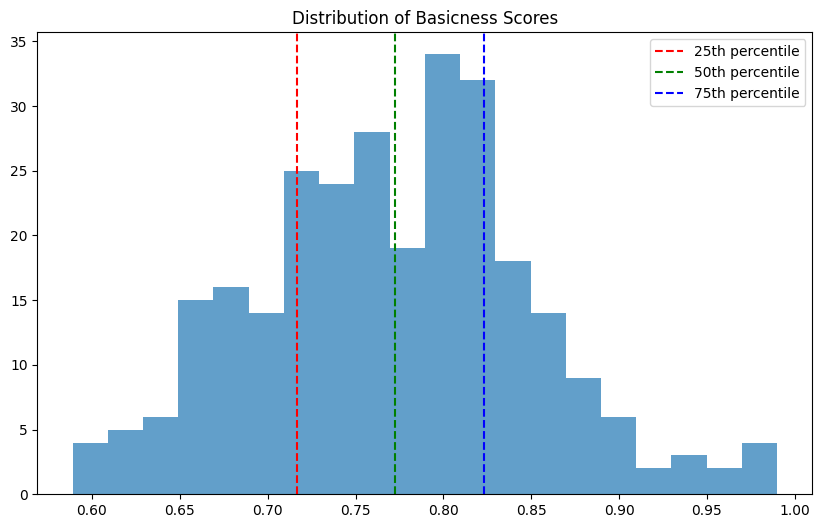

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Get basicness scores
scores = analyzer._OMWBasicnessAnalyzer__result_df["basicness_score_experimental"].values

# Plot histogram to visualize distribution
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=20, alpha=0.7)
plt.axvline(np.percentile(scores, 25), color='r', linestyle='--', label='25th percentile')
plt.axvline(np.percentile(scores, 50), color='g', linestyle='--', label='50th percentile')
plt.axvline(np.percentile(scores, 75), color='b', linestyle='--', label='75th percentile')
plt.legend()
plt.title('Distribution of Basicness Scores')
plt.show()

# Use percentiles as thresholds
thresholds = [
    np.percentile(scores, 25),
    np.percentile(scores, 50),
    np.percentile(scores, 75)
]

In [ ]:
def grid_search_thresholds(analyzer, step=0.05):
    best_accordance = 0
    best_thresholds = None
    
    # Grid search over possible threshold combinations
    for t1 in np.arange(0.1, 0.4, step):
        for t2 in np.arange(t1 + 0.1, 0.7, step):
            for t3 in np.arange(t2 + 0.1, 0.9, step):
                thresholds = [t1, t2, t3]
                accordance = analyzer.evaluate_accordance(thresholds=thresholds)
                
                if accordance > best_accordance:
                    best_accordance = accordance
                    best_thresholds = thresholds
    
    return best_thresholds, best_accordance

# best_thresholds, score = grid_search_thresholds(analyzer)
# print(f"Best thresholds: {best_thresholds}, Accordance: {score:.4f}")

Best thresholds: [np.float64(0.1), np.float64(0.6499999999999999), np.float64(0.7499999999999999)], Accordance: 0.0250


In [14]:
# Literature-based weights
literature_weights = {
    'word_frequency_weight': 0.3,
    'word_length_weight': 2.0,
    'pronounce_complexity_weight': 0.3,
    'n_hyponyms_weight': 0.0,
    'n_synonyms_weight': 0.0,
    'n_senses_weight': 0.0,
    'word_in_children_res_weight': 0.5,
    'word_in_second_lang_learn_res_weight': 0.6,
    'n_syn_senses_weight': 0.0
}

analyzer.set_weights(literature_weights)
analyzer.set_language_specific_weights(None)  # Disable language-specific weights
all_synsets_literature_df = analyzer.analyze_lang_syn_group(word=analysis_name + "_literature_weights", thresholds=fixed_thresholds)
# Reset indexes
all_synsets_literature_df = all_synsets_literature_df.reset_index(drop=True)

# Uniform weights
uniform_weights = {
    'word_frequency_weight': 1.0,
    'word_length_weight': 1.0,
    'pronounce_complexity_weight': 1.0,
    'n_hyponyms_weight': 1.0,
    'n_synonyms_weight': 1.0,
    'n_senses_weight': 1.0,
    'word_in_children_res_weight': 1.0,
    'word_in_second_lang_learn_res_weight': 1.0,
    'n_syn_senses_weight': 1.0
}

analyzer.set_weights(uniform_weights)
analyzer.set_language_specific_weights(None)  # Disable language-specific weights
all_synsets_uniform_df = analyzer.analyze_lang_syn_group(word=analysis_name + "_uniform_weights", thresholds=fixed_thresholds)
# Reset indexes
all_synsets_uniform_df = all_synsets_uniform_df.reset_index(drop=True)


# Re-enable language-specific weights for further analysis
analyzer.set_language_specific_weights(language_specific_weights)

In [ ]:
import os
threshold = 0.4# create the folder results/omw if it does not exist
os.makedirs(get_path_from_root("results/omw"), exist_ok=True)
eval_binary = analyzer.evaluate_basicness_score_binary(threshold=threshold)
print(f"--- Binary evaluation ---")
print(f"threshold: {threshold}")
print(f"weights:")
for key, value in language_specific_weights.items():
    print(f"\t{key}: {value}")
print(eval_binary)

In [ ]:
eval_ord_reg_loss_train = analyzer.evaluate_ordinal_regression_loss(opt_split="train")
eval_ord_reg_loss_test = analyzer.evaluate_ordinal_regression_loss(opt_split="test")
eval_ord_reg_loss_full = analyzer.evaluate_ordinal_regression_loss()
print(f"Ordinal regression loss train: {eval_ord_reg_loss_train}")
print(f"Ordinal regression loss test: {eval_ord_reg_loss_test}")
print(f"Ordinal regression loss full: {eval_ord_reg_loss_full}")

In [ ]:
# accordance_overall = analyzer.get_overall_accordance()
# accordance_test = analyzer.get_overall_accordance(opt_split="test")
# print(f"Overall accordance: {accordance_overall}")
# print(f"Test set overall accordance: {accordance_test}")

In [ ]:
eval_cum_ord_loss_train = analyzer.evaluate_cumulative_ordinal_loss(opt_split="train")
eval_cum_ord_loss_test = analyzer.evaluate_cumulative_ordinal_loss(opt_split="test")
eval_cum_ord_loss_full = analyzer.evaluate_cumulative_ordinal_loss()
print(f"Ordinal cumulative loss train: {eval_cum_ord_loss_train}")
print(f"Ordinal cumulative loss test: {eval_cum_ord_loss_test}")
print(f"Ordinal cumulative loss full: {eval_cum_ord_loss_full}")

In [ ]:
eval_rank_train = analyzer.evaluate_accordance(opt_split="train")
eval_rank_test = analyzer.evaluate_accordance(opt_split="test")
eval_rank_full = analyzer.evaluate_accordance(allow_margin_error=True)
print(f"Rank train eval: {eval_rank_train}")
print(f"Rank test eval: {eval_rank_test}")
print(f"Rank full eval: {eval_rank_full}")

## Basicness Analysis: Optimization

In [ ]:
best_weights, best_df = analyzer.optimize_weights_diff_evo("optimal", "rank", optimize_thresholds=False, optimize_gamma=False, thresholds=fixed_thresholds)

In [ ]:
best_weights

In [ ]:
analyzer.set_weights(best_weights)

In [ ]:
eval_max_post_opt = analyzer.evaluate_basicness_score_max()
print(f"MAX eval post opt: {eval_max_post_opt}")

In [ ]:
eval_mse_post_opt_train = analyzer.evaluate_basicness_score_mse()
eval_mse_post_opt_test = analyzer.evaluate_basicness_score_mse(use_test_set=True)
print(f"MSE train eval post opt: {eval_mse_post_opt_train}")
print(f"MSE test eval post opt: {eval_mse_post_opt_test}")

In [ ]:
eval_rank_post_opt_train = analyzer.evaluate_accordance(thresholds=fixed_thresholds)
eval_rank_post_opt_test = analyzer.evaluate_accordance(use_test_set=True, thresholds=fixed_thresholds)
print(f"Rank train eval post opt: {eval_rank_post_opt_train}")
print(f"Rank test eval post opt: {eval_rank_post_opt_test}")

In [ ]:
eval_ord_reg_loss_train = analyzer.evaluate_ordinal_regression_loss()
eval_ord_reg_loss_test = analyzer.evaluate_ordinal_regression_loss(use_test_set=True)
print(f"Ordinal regression loss train: {eval_ord_reg_loss_train}")
print(f"Ordinal regression loss test: {eval_ord_reg_loss_test}")

In [ ]:
gamma = best_weights['gamma']
eval_cum_ord_loss_train = analyzer.evaluate_cumulative_ordinal_loss(gamma=gamma)
eval_cum_ord_loss_test = analyzer.evaluate_cumulative_ordinal_loss(opt_split=True, gamma=gamma)
print(f"Ordinal cumulative loss train: {eval_cum_ord_loss_train}")
print(f"Ordinal cumulative loss test: {eval_cum_ord_loss_test}")

In [ ]:
accordance_overall = analyzer.get_overall_accordance(thresholds=fixed_thresholds)
accordance_test = analyzer.get_overall_accordance(use_test_set=True, thresholds=fixed_thresholds)
print(f"Overall accordance: {accordance_overall}")
print(f"Test set overall accordance: {accordance_test}")

In [ ]:
best_df

## Plots

In [ ]:
if enable_plots:
    plot_heatmap(all_synsets_lang_syn_df, limit=400)

In [ ]:
if enable_plots:
    plot_spaghettiplot(all_synsets_lang_syn_df, limit=15, show_legend=True)

In [ ]:
if enable_plots:
    # Add rank column to dataframe
    ranked_lang_syn_df = analyzer.add_basicness_rank(all_synsets_lang_syn_df)
    ranked_lang_syn_df

In [ ]:
if enable_plots:
    plot_clustermap(ranked_lang_syn_df, use_rank=True, limit=130)